<a href="https://colab.research.google.com/github/taikingyo/SimpleBERT/blob/master/SimpleBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 簡易版BERT

## ライブラリのインポート

In [0]:
import math
import numpy as np
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras import backend as K

## Attention

In [0]:
class MultiHeadAttention(tfk.models.Model):
  def __init__(self, dim: int, head_num: int, dropout_rate: float, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.dim = dim
    self.head_num = head_num
    self.dropout_rate = dropout_rate
    
    self.query_dense = tfk.layers.Dense(dim, use_bias=False, name='query_dense')
    self.key_dense = tfk.layers.Dense(dim, use_bias=False, name='key_dense')
    self.value_dense = tfk.layers.Dense(dim, use_bias=False, name='value_dense')
    self.out_dense = tfk.layers.Dense(dim, use_bias=False, name='out_dense')
    self.dropout = tfk.layers.Dropout(rate=dropout_rate)
  
  def call(self, inputs):
    if isinstance(inputs, list):
      if len(inputs) == 3:
        main = inputs[0]
        memory = inputs[1]
        attention_mask = inputs[2]
      elif len(inputs) == 2:
        main = inputs[0]
        memory = inputs[0]
        attention_mask = inputs[1]
      else:
        raise ValueError('unmatch list length')
      attention_mask = tf.expand_dims(attention_mask, 1)
      attention_mask = tf.expand_dims(attention_mask, 1) #[batch_size, 1, 1, m_length]
      
      query = self.query_dense(main)   #[batch_size, q_length, dim]
      key = self.key_dense(memory)     #[batch_size, m_length, dim]
      value = self.value_dense(memory) #[batch_size, m_length, dim]
    
      query = self._split(query) #[batch_size, head_num, q_length, dim // head_num]
      key = self._split(key)     #[batch_size, head_num, m_length, dim // head_num]
      value = self._split(value) #[batch_size, head_num, m_length, dim // head_num]
    
      depth = self.dim // self.head_num
      query *= depth ** -0.5
    
      logit = tf.matmul(query, key, transpose_b=True) #[batch_size, head_num, q_length, m_length]
      logit += tf.cast(attention_mask, tf.float32) * main.dtype.min
    
      weight = tf.nn.softmax(logit, name='weight')
      weight = self.dropout(weight)
    
      out = tf.matmul(weight, value) #[batch_size, head_num, q_length, dim // head_num]
      out = self._combine_head(out) #[batch_size, q_length, dim]
    
      return self.out_dense(out) #[batch_size, q_length, dim]
    else:
      raise ValueError('inputs expect list of Tensor')
    
  def _split(self, x):
    '''
    入力tensor(x)をnHeadに分割
    input_shape:  [batch_size, length, dim]
    output_shape: [batch_size, head_num, length, dim // head_num]
    '''
    
    with tf.name_scope('split'):
      batch_size, length, dim = tf.unstack(tf.shape(x))
      x = tf.reshape(x, [batch_size, length, self.head_num, self.dim // self.head_num])
      return tf.transpose(x, [0, 2, 1, 3])
    
  def _combine_head(self, x):
    '''
    入力tensor(x)の各Headを結合
    input_shape:  [batch_size, head_num, length, dim // head_num]
    output_shape: [batch_size, length, dim]
    '''
    
    with tf.name_scope('combine'):
      batch_size, _, length, _ = tf.unstack(tf.shape(x))
      x = tf.transpose(x, [0, 2, 1, 3])
      return tf.reshape(x, [batch_size, length, self.dim])

## Attention前後の処理
*   FeedForwardNetwork

> dim * 4、dimの2層の全結合層

*   LayerNormalization

> 層ごとの正規化

*   ResidualNormalizationWrapper

> AttentionとFFNにnormalizationとresidual connectionを適用するラッパー




In [0]:
class FeedForwardNetwork(tfk.models.Model):
  def __init__(self, dim: int, dropout_rate: float, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.dim = dim
    self.dropout_rate = dropout_rate
    
    self.dense_1 = tfk.layers.Dense(dim * 4, use_bias=True, activation=tf.nn.relu, name='filter')
    self.dense_2 = tfk.layers.Dense(dim, use_bias=True, name='output')
    self.dropout = tfk.layers.Dropout(rate=dropout_rate)
    
  def call(self, inputs):
    '''
    input_shape: [batch_size, length, dim]
    output_shape: [batch_size, length, dim]
    '''
    tensor = self.dense_1(inputs)
    tensor = self.dropout(tensor)
    return self.dense_2(tensor)

class LayerNormalization(tfk.layers.Layer):
  def build(self, input_shape):
    dim = input_shape[-1]
    self.scale = self.add_weight('layer_norm_scale', shape=[dim], initializer=tf.ones_initializer())
    self.bias = self.add_weight('layer_norm_bial', [dim], initializer=tf.zeros_initializer())
    super().build(input_shape)
    
  def call(self, x: tf.Tensor, epsilon: float = 1e-6):
    mean = tf.reduce_mean(x, axis=[-1], keepdims=True)
    variance = tf.reduce_mean(tf.square(x - mean), axis=[-1], keepdims=True)
    norm_x = (x - mean) / tf.sqrt(variance + epsilon)
    
    return norm_x * self.scale + self.bias
  
class ResidualNormalizationWrapper(tfk.models.Model):
  def __init__(self, layer: tfk.layers.Layer, dropout_rate: float, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.layer = layer
    self.norm = LayerNormalization()
    self.dropout =  tfk.layers.Dropout(rate=dropout_rate)
    
  def call(self, input):
    if isinstance(input, list):
      head = input[0]
      tail = input[1:]
      head = self.norm(head)
      tensor = self.layer([head] + tail)
      tensor = self.dropout(tensor)
      tensor += head
    else:
      tensor = self.norm(input)
      tensor = self.layer(tensor)
      tensor = self.dropout(tensor)
      tensor += input
    return tensor

## 位置情報の埋め込み

In [0]:
class PositionalEncoder(tfk.layers.Layer):
  def __init__(self, length: int, dim: int, *args, **kwargs):
    depth_counter = np.arange(dim) // 2 * 2
    depth_matrix = np.tile(np.expand_dims(depth_counter, 0), (length, 1))
    depth_matrix = np.power(10000.0, depth_matrix / dim)
    
    phase = np.arange(dim) % 2 * math.pi / 2
    phase_matrix = np.tile(np.expand_dims(phase, 0), (length, 1))
    
    pos_counter = np.arange(length)
    pos_matrix = np.tile(np.expand_dims(pos_counter, 1), (1, dim))
    
    positional_encoder = np.sin(pos_matrix / depth_matrix + phase_matrix)
    positional_encoder = np.expand_dims(positional_encoder, 0)
    self.pe = tf.constant(positional_encoder)
    super(PositionalEncoder, self).__init__(*args, **kwargs)
  def call(self, inputs):
    fl_type = inputs.dtype
    batch_size, _, _ = tf.unstack(tf.shape(inputs))
    
    return tf.tile(tf.cast(self.pe, fl_type), [batch_size, 1, 1])

## エンコーダ
SelfAttentionと前後の処理をまとめて繰り返し処理

In [0]:
class Encoder(tfk.models.Model):
  def __init__(
    self,
    vocab: int,
    hopping_num: int,
    head_num: int,
    dim: int,
    dropout_rate: float,
    max_length: int,
    *args,
    **kwargs
  ):
    super(Encoder, self).__init__(*args, **kwargs)
    self.hopping_num = hopping_num
    self.head_num = head_num
    self.dim = dim
    self.dropout_rate = dropout_rate
    
    self.attention_list: List[List[tfk.models.Model]] = []
    
    for _ in range(hopping_num):
      attention = MultiHeadAttention(dim, head_num, dropout_rate, name='attention')
      ffn = FeedForwardNetwork(dim, dropout_rate, name='ffn')
      self.attention_list.append([
          ResidualNormalizationWrapper(attention, dropout_rate, name='attention_wrapper'),
          ResidualNormalizationWrapper(ffn, dropout_rate, name='ffn_wrapper')
      ])
      
    self.normalization = LayerNormalization()
    
  def call(self, inputs):
    query = inputs[0]
    mask = inputs[1]
    
    for i, layer in enumerate(self.attention_list):
      attention, ffn = tuple(layer)
      with tf.name_scope(f'hopping_{i}'):
        query = attention([query, mask])
        query = ffn(query)
        
    return self.normalization(query)

## BERT本体
トークン・セグメント・ポジションの埋め込みを足し合わせ、繰り返しエンコーダに通した後、事前学習タスクの隣接文・ランダムマスク用にそれぞれ全結合層で出力  
２値の隣接文タスクと、ボキャブラリ次元のランダムマスクでは損失が大きく異なるので、loss_weightsで調整（適当）

デコーダは使用しないので、トランスフォーマではなくエンコーダをそのまま呼び出し

In [0]:
class SimpleBERT:
  def __init__(
      self,
      vocab_num: int,
      max_length: int,
      unit_num: int=6,
      hopping_num: int=6,
      head_num: int=8,
      dim: int=256,
      dropout_rate: float=0.1,
      init_lr: float=1e-4,
  ) -> None:
    self.vocab_num = vocab_num
    self.max_length = max_length
    self.encoder_list = []
    for i in range(unit_num):
      self.encoder_list.append(Encoder(self.vocab_num, hopping_num, head_num, dim, dropout_rate, max_length, name=f'encoder_{i}'))
      
    inputs1 = tfk.Input(shape=(max_length,), dtype='int32', name='input_main') #[batch_size, max_length]
    inputs2 = tfk.Input(shape=(max_length,), dtype='int32', name='input_segment_type') #[batch_size, max_length]
    mask = tfk.layers.Lambda(lambda x: K.cast(K.not_equal(x, 0), tf.float32))(inputs1)
    mask = tfk.layers.Lambda(lambda x: K.tile(K.expand_dims(x, -1), [1, 1, dim]), name='embedd_mask')(mask)
    pad = tfk.layers.Lambda(lambda x: K.cast(K.equal(x, 0), tf.float32), name='padding_mask')(inputs1)
    
    token_embedded = tfk.layers.Embedding(input_dim=self.vocab_num, output_dim=dim, input_length=max_length, name='token_embedding')(inputs1)
    token_embedded = tfk.layers.Lambda(lambda x: x * (dim ** 0.5), name='scaling')(token_embedded)
    position_embedded = PositionalEncoder(max_length, dim)(token_embedded)
    segment_embedded = tfk.layers.Embedding(input_dim=3, output_dim=dim, input_length=max_length, name='segment_embedding')(inputs2)
    embedded = tfk.layers.Add()([token_embedded, position_embedded, segment_embedded])
    embedded = tfk.layers.Dropout(rate=dropout_rate)(embedded)
    embedded = tfk.layers.Multiply()([embedded, mask])
    
    query = embedded
    for encoder in self.encoder_list:
      query = encoder([query, pad])
    
    flat = tfk.layers.Flatten()(query)
    sentence_shuffle_y_ = tfk.layers.Dense(1, activation='sigmoid', name='shuffle')(flat)
    random_mask_y_ = tfk.layers.Dense(self.vocab_num, activation='softmax', name='mask')(flat)
    
    self.model = tfk.models.Model(inputs=[inputs1, inputs2], outputs=[sentence_shuffle_y_, random_mask_y_])
    self.model.compile(
        optimizer=tfk.optimizers.Adam(lr=init_lr, decay=0.01),
        loss={'shuffle': 'binary_crossentropy', 'mask': 'categorical_crossentropy'},
        loss_weights={'shuffle': 0.8, 'mask': 0.2},
        metrics=['accuracy'])
    
  def pretraining(self, x1, x2, y1, y2, batch_size=32, epochs=1):
    hist = self.model.fit([x1, x2], [y1, y2], batch_size=batch_size, epochs=epochs)
    return hist

## 辞書の管理等、テキスト処理

In [0]:
class TextProcessor:
  def __init__(self, doc, unk_lim: int=1):
    self.unk_lim = unk_lim
    self._build_dictionary(doc)
    
  def _build_dictionary(self, doc):
    #単語文字列から整数値への変換辞書作成
    
    words = [] #全単語リスト
    for context in doc:
      for tolk in context:
        words += tolk
    vocab = sorted(list(set(words))) #語彙リスト
    
    #低頻度後の置き換え処理
    word2indice = dict((w, i) for i, w in enumerate(vocab))
    cnt = np.zeros(len(vocab))
    for i in range(len(words)):
      cnt[word2indice[words[i]]] += 1
    vocab_unk = [] #低頻度語・未知語リスト（未使用）
    for i in range(len(cnt)):
      if cnt[i] <= self.unk_lim:
        vocab_unk.append(vocab[i])
        vocab[i] = '<UNK>'
        
    #制御コード＋語彙リスト
    vocab = ['<PAD>', '<MSK>', '<CLS>', '<SEP>'] + sorted(list(set(vocab)))
    if not '<UNK>' in vocab:
      vocab += ['<UNK>']
      
    #語彙辞書
    word2indice = dict((w, i) for i, w in enumerate(vocab))
    indice2word = dict((i, w) for i, w in enumerate(vocab))
    
    self.vocab = vocab
    self.vocab_unk = vocab_unk
    self.vocab_num = len(vocab)
    self.word2indice = word2indice
    self.indice2word = indice2word
    
  def build_training_data(self, data, max_length):
    #sentence shuffle
    double_sentences = [] #ベースの隣接文
    single_sentences = [] #シャッフル用予備文
    for context in data:
      if len(context) == 1:
        single_sentences.append(context[0])
      else:
        double_sentences += tuple(zip(context[:-1], context[1:]))
        
    if len(single_sentences) < 1:
      np.random.shuffle(double_sentences)
      (s1, s2) = double_sentences[0]
      single_sentences.append(s1)
      single_sentences.append(s2)
      double_sentences = double_sentences[1:]
    np.random.shuffle(single_sentences)
    
    #確率0.25でそれぞれ隣接文の前半・後半を予備文に置き換え（そのままでは使えない単文を優先）
    sentences = []
    y1 = np.zeros(len(double_sentences), dtype=int) #隣接文判別ターゲット
    for i, (s1, s2) in enumerate(double_sentences):
      r = np.random.rand()
      if r < 0.25:
        single_sentences.append(s1)
        s1 = single_sentences[0]
        single_sentences = single_sentences[1:]
      elif r < 0.5:
        single_sentences.append(s2)
        s2 = single_sentences[0]
        single_sentences = single_sentences[1:]
      else:
        y1[i] = 1
      sentence = ['<CLS>'] + s1 + ['<SEP>'] + s2 + ['<SEP>']
      if len(sentence) > max_length:
        sentence = sentence[:max_length]
      sentences.append(sentence)
    y1 = np.expand_dims(y1, axis=-1)
      
    #random masking
    x2 = np.zeros((len(sentences), max_length), dtype=int) #セグメントタイプ(文１:1、文２:2、パディング:0)
    y2 = np.zeros((len(sentences), self.vocab_num), dtype=int) #ランダムマスクターゲット(n-hot vector)
    masked_sentences = []
    for i, sentence in enumerate(sentences):
      label = 1
      masked = []
      for j, word in enumerate(sentence):
        x2[i][j] = label
        if not word in self.word2indice:
          word = '<UNK>'
        elif word == '<SEP>':
          label = 2
        elif not(word.startswith('<') and word.endswith('>')):
          if np.random.rand() < 0.13:
            y2[i][self.word2indice[word]] = 1
            word = '<MSK>'
        masked.append(word)
      masked_sentences.append(masked)
        
    x1 = self.toIndices(masked_sentences, max_length) #main input
      
    return x1, x2, y1, y2
    
  def toIndices(self, sentences, max_length):
    #文字列からone-hot表現へ変換
    indices = np.zeros((len(sentences), max_length), dtype=int)
    for i, sentence in enumerate(sentences):
      if len(sentence) > max_length:
        sentence = sentence[:max_length]
      for j, word in enumerate(sentence):
        if not word in self.word2indice:
          word = '<UNK>'
        indices[i][j] = self.word2indice[word]
          
    return indices
    
  def toWords(self, indices):
    #one-hot表現から文字列へ変換
    sentences = []
    for line in indices:
      sentence = []
      for indice in line:
        if indice == 0:
          break
        sentence.append(self.indice2word[indice])
      sentences.append(sentence)
        
    return sentences

# テスト

## 事前学習に用いるテキストのアップロード
半角スペースで分かち書き済み、1行で１つの発話（文）、空行で文脈（段落）を区切ったテキストを使用

In [0]:
from google.colab import files
uploaded = files.upload()

## テスト用データの作成
段落・文・単語の3階のテンソルを作成

Colaboratoryでの試用の為、パラメータはかなり抑えてます
テキストの量や語彙数によって、要調整

In [0]:
doc = []
for file in uploaded:
  context = []
  text = open(file, 'r').read().strip().split('\n')
  for tolk in text:
    if tolk == '' and len(context) != 0:
      doc.append(context)
      context = []
    else:
      context.append(tolk.split(' '))
  doc.append(context)
  
max_length = 128 #最大系列長
unit_num = 2     #重ねるエンコーダの数
unk_lim = 1      #低頻度語を未知語にまとめるカウント閾値

processor = TextProcessor(doc, unk_lim=unk_lim)
bert = SimpleBERT(processor.vocab_num, max_length=max_length, unit_num=unit_num)

## 事前学習テスト
メモリ節約のため小分けにして、バッチ処理（BERT本体側とあわせて2重）

In [0]:
epochs = 3
batch_size = 500
steps = -(-len(doc) // batch_size)

for i in range(epochs):
  np.random.shuffle(doc)
  print('epochs: ', i)
  
  for j in range(steps):
    start = j * batch_size
    end = min(start + batch_size, len(doc))
    x1, x2, y1, y2 = processor.build_training_data(doc[start:end], max_length=max_length)
    hist = bert.pretraining(x1, x2, y1, y2)

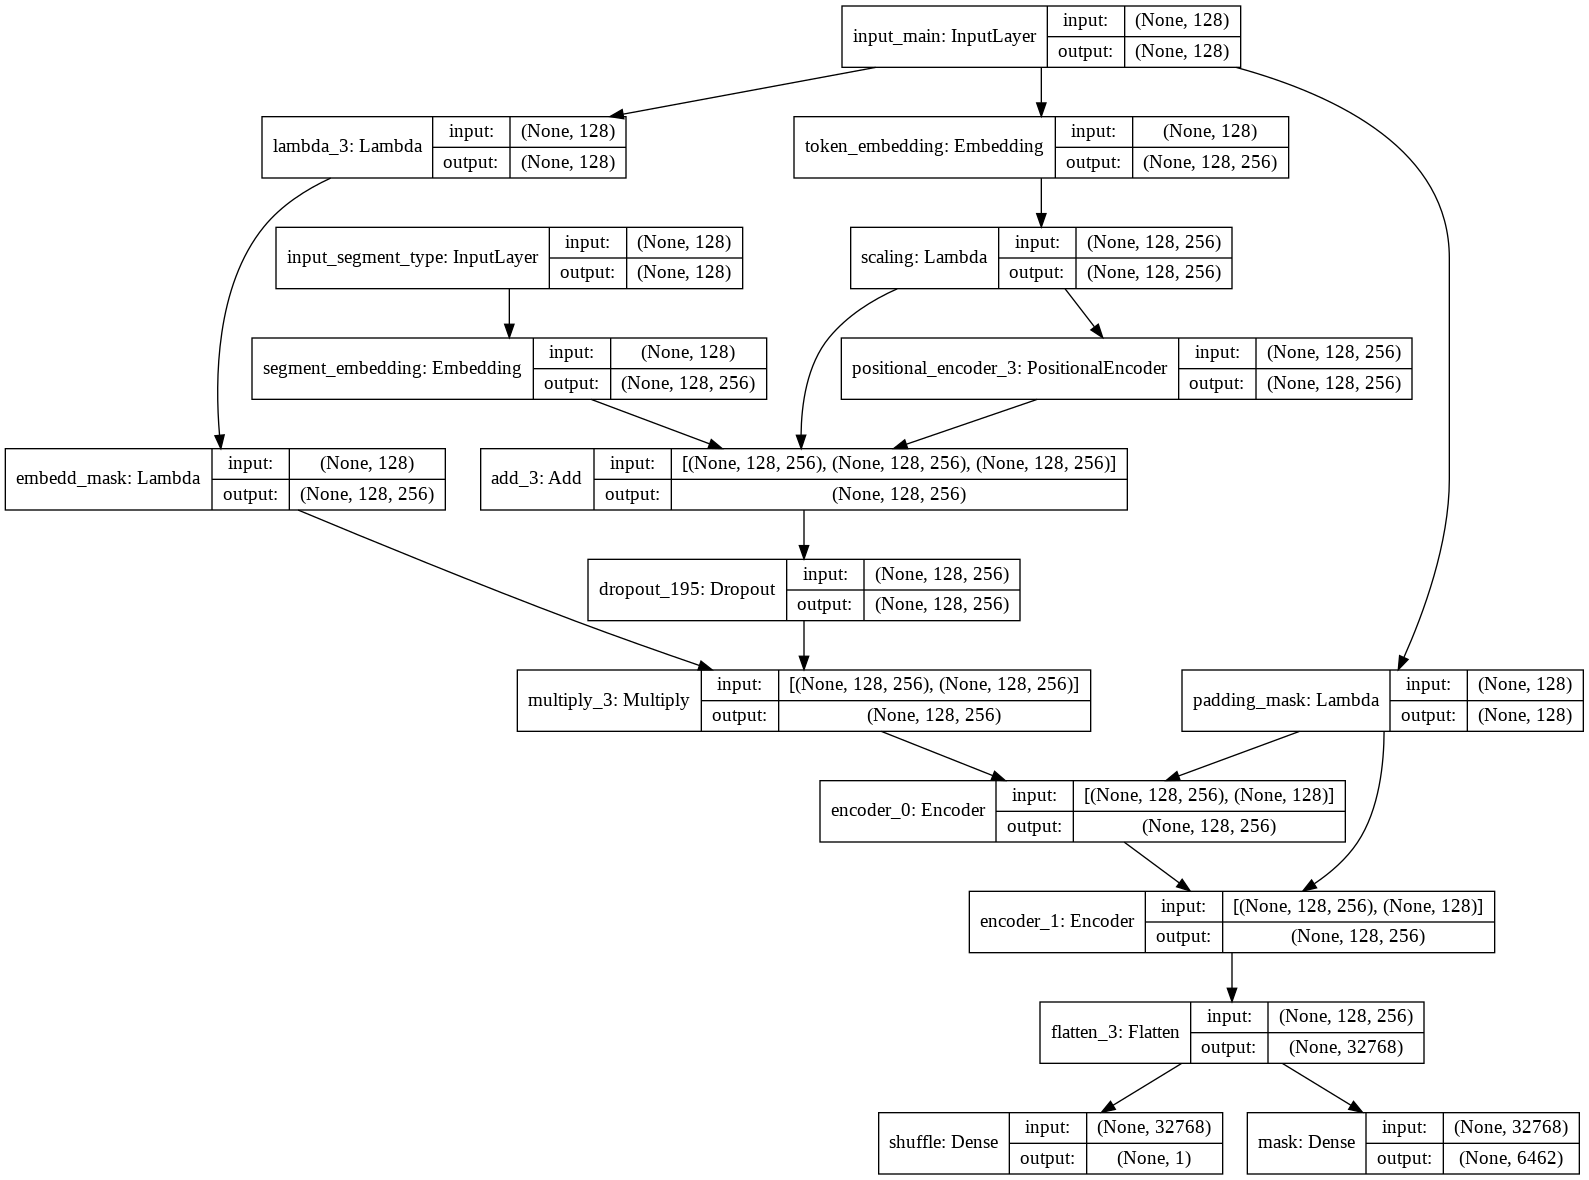

In [0]:
from IPython.display import Image, display_png
img = 'model.png'
tfk.utils.plot_model(bert.model, show_shapes=True, to_file=img)
display_png(Image(img))